Import Statements and getting the Wikipedia content

In [1]:
import requests 
from bs4 import BeautifulSoup 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
r = requests.get(URL) 

/home/dhruvi/.local/lib/python3.5/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Parsing the wiki content with beautiful soup

In [2]:
soup = BeautifulSoup(r.content, 'html5lib') 
table = soup.find('table', attrs = {'class':'wikitable'}) 
tbody = table.find('tbody') 

Parsing each row of the table and creating a dataframe

In [3]:
each_ = []
for row in tbody.findAll('tr'):
        cols = row.find_all('td')
        if len(cols):
            cols = [ele.text.strip() for ele in cols]
            each_.append([ele for ele in cols if ele])

df = pd.DataFrame.from_records(each_,columns=['PostalCode','Borough','Neighbourhood'])

Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [4]:
df_not_null = df.replace(to_replace=r'^Not assigned$', value=np.nan, regex=True)
df_not_null.dropna(subset=['Borough'],inplace=True)

If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 

In [5]:
def replace_nan_neighbourhd(x):
    if x['Neighbourhood'] is np.nan:
        x['Neighbourhood'] = x['Borough']
    return x
df_not_null = df_not_null.apply(replace_nan_neighbourhd, axis=1)

More than one neighborhood can exist in one postal code area. Such multiple rows will be combined into one row with the neighborhoods separated with a comma

In [6]:
def join_neighbourhd(x):
    x['Neighbourhood'] = ', '.join((x['Neighbourhood'].values))
    return x.iloc[0]
df_grp_by = df_not_null.groupby('PostalCode').apply(join_neighbourhd)
df_grp_by.drop(columns=['PostalCode'],inplace=True)
df_grp_by.head(20)

,Borough,Neighbourhood
PostalCode,,
M1B,Scarborough,"Rouge, Malvern, Rouge, Malvern"
M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
M1E,Scarborough,"Guildwood, Morningside, West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae
M1J,Scarborough,Scarborough Village
M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"


Shape of the final dataframe

In [7]:
df_grp_by.shape

(103, 2)

Get the geospatial data and join the 2 dataframes

In [8]:
#!wget -q 'http://cocl.us/Geospatial_data' -O Geospatial_data.csv
df_geo_data = pd.read_csv('Geospatial_data.csv')
df_geo_data.columns = ['PostalCode','Latitude','Longitude']
df_grp_by = df_grp_by.join(df_geo_data.set_index('PostalCode'),on='PostalCode',how='left')

Filtering rows containing Toronto word

In [9]:
df_toronto = df_grp_by[df_grp_by['Borough'].str.contains('Toronto',case=True, regex=True)]

In [25]:
df_toronto.head()


,index,PostalCode,Borough,Neighbourhood,Latitude,Longitude,labels
0,0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1
1,1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1
2,2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1
3,3,M4M,East Toronto,Studio District,43.659526,-79.340923,1
4,4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0


Grouping the neighbourhood by Borough. DownTown Toronto has most number of neighbourhood as shown in the bar chart

In [11]:
df_toronto_grp_by = df_toronto.groupby('Borough').mean()
df_toronto_grp_by = df_toronto_grp_by.reset_index()


Text(0, 0.5, '# Neighbourhood')

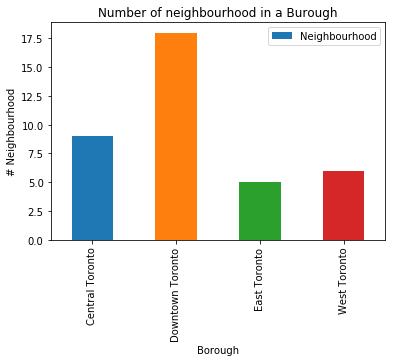

In [12]:
(df_toronto.groupby('Borough').count()).plot(y='Neighbourhood',kind='bar')
plt.title('Number of neighbourhood in a Burough')
plt.ylabel('# Neighbourhood')

Analyzing the Toronto data

In [13]:
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
import folium 
class FourSquareAPI():
    def __init__(self, client_id, client_secret, version='20180604', limit=30):
        self.client_id = client_id
        self.client_secret = client_secret
        self.version = version
        self.limit = limit
        
    def get_venue_search(self, latitude, longitude, search_query, radius=500):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.\
format(self.client_id, self.client_secret, latitude, longitude, self.version, search_query, radius, self.limit)
        results = requests.get(url).json()
        venues = results['response']['venues']
        df = json_normalize(venues)
        # keep only columns that include venue name, and anything that is associated with location
        filtered_columns = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
        dataframe_filtered = df.loc[:, filtered_columns]

        # function that extracts the category of the venue
        def get_category_type(row):
            try:
                categories_list = row['categories']
            except:
                categories_list = row['venue.categories']

            if len(categories_list) == 0:
                return None
            else:
                return categories_list[0]['name']

        # filter the category for each row
        dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
        dataframe_filtered['search_q'] = search_query
        # clean column names by keeping only last term
        dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

        dataframe_filtered
        return dataframe_filtered
    
    def get_trending_places(self, latitude, longitude):
        url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.\
        format(self.client_id, self.client_secret, latitude, longitude, self.version)
        results = requests.get(url).json()
        if len(results['response']['venues']) == 0:
            trending_venues_df = 'No trending venues are available at the moment!'
        else:
            trending_venues = results['response']['venues']
            trending_venues_df = json_normalize(trending_venues)
            columns_filtered = ['name', 'categories'] + ['location.distance', 'location.city', 'location.postalCode', 'location.state', 'location.country', 'location.lat', 'location.lng']
            trending_venues_df = trending_venues_df.loc[:, columns_filtered]
            trending_venues_df['categories'] = trending_venues_df.apply(get_category_type, axis=1)
        return trending_venues_df
fsq = FourSquareAPI('QRTP4LWZZWCQEVRBNPS0P4D1W33WZZ4YMSYDZXJ0NISIL3JI','NVKCW0IHZFGE340QPJGVG2AX1C1DZ2V3QKNVGCZYTWI4TNIK')

Considering School, Cafes, Hospital, Park ,Offices and Stores as basic ammenities, Data about these basic ammenities was fetched from foursquare api and as can be seen in the last Canada map, most of the ammenities are concentrated in the centre (mean) of the meighbour distribution

In [14]:

def get_nearby_places(each_):
    each_venue = fsq.get_venue_search(each_['Latitude'], each_['Longitude'],'school')
    each_['schools'] = len(each_venue.index)
    lat_long = each_venue[['lat','lng']].values
    
    each_venue = fsq.get_venue_search(each_['Latitude'], each_['Longitude'],'cafe')
    each_['cafe'] = len(each_venue.index)
    lat_long = np.vstack((lat_long, each_venue[['lat','lng']].values))
    
    each_venue = fsq.get_venue_search(each_['Latitude'], each_['Longitude'],'hospital')
    each_['hospital'] = len(each_venue.index)
    lat_long = np.vstack((lat_long, each_venue[['lat','lng']].values))
    
    each_venue = fsq.get_venue_search(each_['Latitude'], each_['Longitude'],'park')
    each_['park'] = len(each_venue.index)
    lat_long = np.vstack((lat_long, each_venue[['lat','lng']].values))
    
    each_venue = fsq.get_venue_search(each_['Latitude'], each_['Longitude'],'office')
    each_['offices'] = len(each_venue.index)
    lat_long = np.vstack((lat_long, each_venue[['lat','lng']].values))
    
        
    each_venue = fsq.get_venue_search(each_['Latitude'], each_['Longitude'],'store')
    each_['stores'] = len(each_venue.index)
    lat_long = np.vstack((lat_long, each_venue[['lat','lng']].values))
    
    each_['ammenities_lat_long'] = lat_long
    return each_ 
df_toronto_grp_by = df_toronto_grp_by.apply(get_nearby_places, axis=1)

In [15]:
ammenities = []
for index, each_  in df_toronto_grp_by.iterrows():
    ammenities.extend(each_['ammenities_lat_long'])


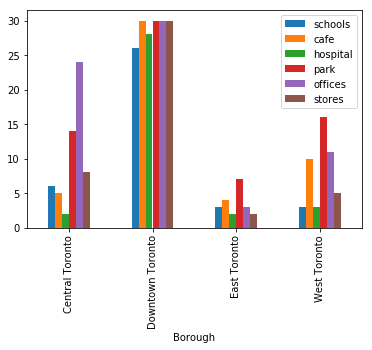

In [16]:
df_toronto_grp_by.set_index('Borough').plot(kind='bar',y=['schools','cafe','hospital','park','offices','stores'])

Kmeans Clustering of the coordinates divide Toronto into 4 clusters, cluster in brown with least neighbourhoods and the purple one with most neighbourhoods

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

X = df_toronto[['Latitude','Longitude']].values
Clus_dataSet = StandardScaler().fit_transform(X)
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
df_toronto['labels'] = labels

In [31]:
toronto_grp_by_map = folium.Map(location=[43.679563,-79.377529], zoom_start=13) # generate map centred around the Conrad Hotel

for index, each_ in df_toronto_grp_by.iterrows():
    folium.features.CircleMarker(
        [each_['Latitude'], each_['Longitude']],
        radius=10,
        color='red',
        popup=each_['Borough'],
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(toronto_grp_by_map)

In [35]:
# df_toronto  = df_toronto.reset_index()
colors =['orange',
    'purple',
    'darkgreen',
        'brown']
for index, each_ in df_toronto.iterrows():
    folium.features.CircleMarker(
        [each_['Latitude'], each_['Longitude']],
        radius=5,
        color=colors[each_['labels']],
        popup='Neighbourhood: '+ each_['PostalCode'],
        fill = True,
        fill_color = colors[each_['labels']],
        fill_opacity = 0.6
    ).add_to(toronto_grp_by_map)


In [36]:
for each_ in ammenities:
    folium.features.CircleMarker(
        [each_[0], each_[1]],
        radius=2,
        color='black',
        fill = True,
        fill_color = 'black'
    ).add_to(toronto_grp_by_map)
toronto_grp_by_map